In [19]:
import pandas as pd
import re
from thefuzz import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# Helper functions
# -----------------------------

def clean_text(s):
    """Basic text normalization"""
    if pd.isna(s):
        return ""
    s = str(s) # Convert to string to handle non-string types
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)  # keep alphanum + space
    s = re.sub(r"\s+", " ", s).strip()
    return s

def best_fuzzy_match(query, choices, scorer=fuzz.token_set_ratio, threshold=80):
    """Find best fuzzy match for query from choices"""
    best_match, score = process.extractOne(query, choices, scorer=scorer)
    if score >= threshold:
        return best_match, score
    return None, score

In [20]:
def match_queries(resolved_path, new_path, output_path="query_matches.csv"):
    resolved_df = pd.read_csv(resolved_path)
    new_df = pd.read_csv(new_path)

    # Identify the correct columns
    if "Pre_Resolved_Query" in resolved_df.columns:
        resolved_col = "Pre_Resolved_Query"
    else:
        resolved_col = resolved_df.columns[0]

    if "New_Query" in new_df.columns:
        new_col = "New_Query"
    else:
        new_col = new_df.columns[0]

    # Clean text
    resolved_df["clean"] = resolved_df[resolved_col].apply(clean_text)
    new_df["clean"] = new_df[new_col].apply(clean_text)

    resolved_queries = resolved_df["clean"].tolist()

    matches = []
    for q in new_df.itertuples():
        # Fuzzy match
        fuzzy_match, fuzzy_score = best_fuzzy_match(
            q.clean, resolved_queries, scorer=fuzz.token_set_ratio, threshold=80
        )

        # TF-IDF cosine similarity
        vectorizer = TfidfVectorizer().fit(resolved_queries + [q.clean])
        tfidf_matrix = vectorizer.transform(resolved_queries + [q.clean])
        cosine_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()
        best_idx = cosine_sim.argmax()
        cosine_match = resolved_queries[best_idx]
        cosine_score = cosine_sim[best_idx]

        matches.append({
            "new_query": getattr(q, new_col),
            "fuzzy_match": fuzzy_match,
            "fuzzy_score": fuzzy_score,
            "cosine_match": cosine_match,
            "cosine_score": cosine_score,
        })

    out_df = pd.DataFrame(matches)
    out_df.to_csv(output_path, index=False)
    print(f"✅ Query matches saved to {output_path}")


In [21]:
def match_names(base_path, variations_path, output_path="name_matches.csv"):
    base_df = pd.read_csv(base_path)
    var_df = pd.read_csv(variations_path)

    # Pick the correct text columns
    if "Base_Name" in base_df.columns:
        base_col = "Base_Name"
    elif "name" in base_df.columns:
        base_col = "name"
    else:
        base_col = base_df.columns[0]  # fallback

    if "Name_Variation" in var_df.columns:
        var_col = "Name_Variation"
    elif "name" in var_df.columns:
        var_col = "name"
    else:
        var_col = var_df.columns[0]  # fallback

    # Normalize names
    base_df["clean"] = base_df[base_col].apply(normalize_name)
    var_df["clean"] = var_df[var_col].apply(normalize_name)

    base_names = base_df["clean"].tolist()

    matches = []
    for n in var_df.itertuples():
        best_match, score = best_fuzzy_match(
            n.clean, base_names, scorer=fuzz.token_sort_ratio, threshold=80
        )
        matches.append({
            "variation": getattr(n, var_col),
            "base_match": best_match,
            "score": score,
        })

    out_df = pd.DataFrame(matches)
    out_df.to_csv(output_path, index=False)
    print(f"✅ Name matches saved to {output_path}")


In [22]:

if __name__ == "__main__":
    # Task 1
    match_queries("resolved_queries.csv", "new_queries.csv")

    # Task 2
    match_names("base_names.csv", "name_variations.csv")

✅ Query matches saved to query_matches.csv
✅ Name matches saved to name_matches.csv



🔎 Sample Query Matches:
                                   new_query  \
0           Unabel to conect to the internet   
1                  Can’t connect to internet   
2                        Intenet not working   
3               Payment failed while chekout   
4  Payment did not go through during chckout   
5                 Payment issue at check out   
6   Application crashes when opening setings   
7           App crash when going to settings   
8           Settings cause the app to chrash   
9              Forgot passwrd and cant reset   

                         fuzzy_match  fuzzy_score  \
0  unable to connect to the internet           95   
1  unable to connect to the internet           86   
2                                NaN           49   
3     payment failed during checkout           83   
4                                NaN           70   
5                                NaN           57   
6  app crashes when opening settings           88   
7  app crashes when op

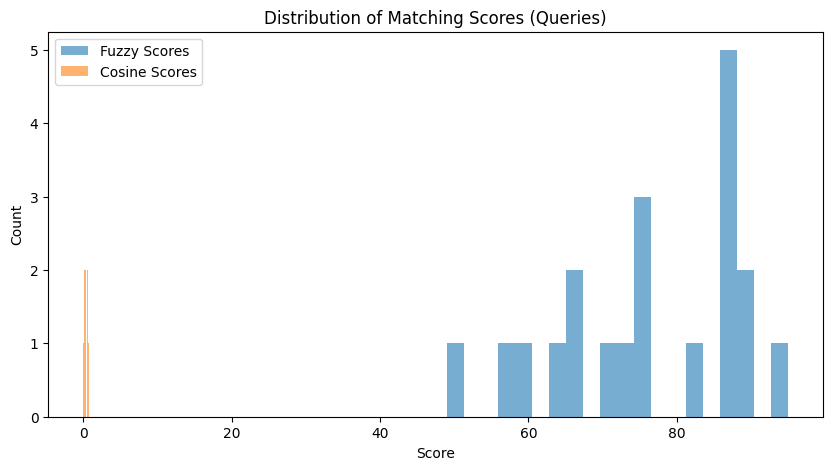


👤 Sample Name Matches:
       variation     base_match  score
0   Thomas  King    thomas king    100
1     ThomasKing            NaN     57
2   Maria Garcia   maria garcia    100
3      MaryLewis            NaN     53
4       Nancy W.            NaN     74
5   Dani3l Scott   daniel scott     92
6    JOHN  smith     john smith    100
7  linda johnson  linda johnson    100
8   N@ncy Wright   nancy wright     92
9  William Davis  william davis    100


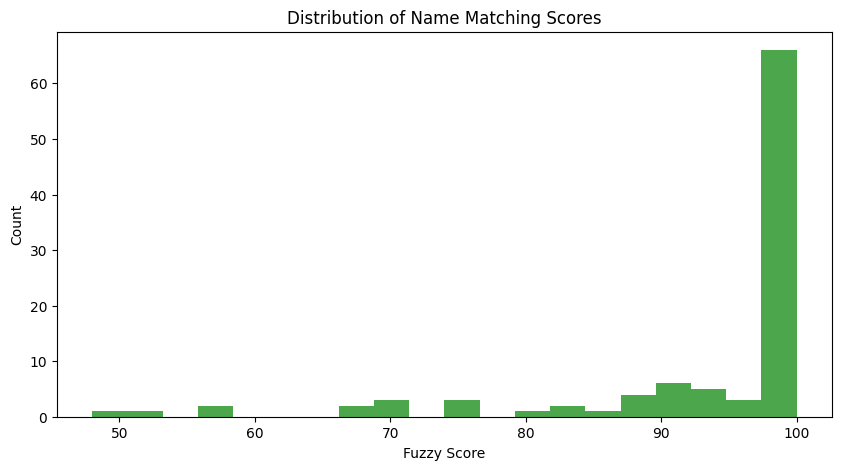

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Test / Visualize Query Matches
# -----------------------------
def visualize_query_matches(path="query_matches.csv"):
    df = pd.read_csv(path)

    print("\n🔎 Sample Query Matches:")
    print(df.head(10))

    # Plot score distributions
    plt.figure(figsize=(10,5))
    plt.hist(df["fuzzy_score"], bins=20, alpha=0.6, label="Fuzzy Scores")
    plt.hist(df["cosine_score"], bins=20, alpha=0.6, label="Cosine Scores")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title("Distribution of Matching Scores (Queries)")
    plt.legend()
    plt.show()

# -----------------------------
# Test / Visualize Name Matches
# -----------------------------
def visualize_name_matches(path="name_matches.csv"):
    df = pd.read_csv(path)

    print("\n👤 Sample Name Matches:")
    print(df.head(10))

    # Plot score distribution
    plt.figure(figsize=(10,5))
    plt.hist(df["score"], bins=20, alpha=0.7, color="green")
    plt.xlabel("Fuzzy Score")
    plt.ylabel("Count")
    plt.title("Distribution of Name Matching Scores")
    plt.show()

# -----------------------------
# Run tests
# -----------------------------
if __name__ == "__main__":
    visualize_query_matches()
    visualize_name_matches()


In [24]:
import pandas as pd
print(pd.read_csv("resolved_queries.csv").head())


   Query_ID                    Pre_Resolved_Query
0         1     Unable to connect to the internet
1         2        Payment failed during checkout
2         3     App crashes when opening settings
3         4   Forgot password and unable to reset
4         5  Unable to upload files to the server
